# The HDR Plot for the freefall example

## Introduction

In this document, we present how to apply the HDR algorithm on an example which models the fall of an object in a viscous fluid.

## Description

We consider a mass which is dropped in a viscous fluid. At initial time, a mass is vertically projected in a viscous fluid upward. The mass goes up, then falls down. The speed of the mass is limited by the drag force that the fluid generates on the mass. We make the hypothesis that the drag force depends linearily on the speed of the mass.

The differential equation which models the problem is then :
$$
m \frac{dv}{dt} = -m g - cv
$$
where 
- $v$ is the vertical speed (m/s), 
- $m$ is the mass (kg), 
- $g$ is the gravity coefficient (m/s2),
- $c$ is the linear drag coefficient (kg/s).

A positive speed in considered as in the upward direction. 

The solution of this differential equation can be derived with simple calculations when the drag depends linearily on the speed, which is an acceptable approximation in a viscous fluid. This approximation is not correct in a less dense fluid such as air, where the drag force can be modeled by a function which depends quadratically on the speed of the mass.

The height of the mass depending on the time is:
$$
z(t) = z_0 + v_{inf} t+ \tau (v_0-v_{inf})(1-exp(-t/\tau))
$$
for any $t\in [0,tmax]$, where 
- $z$ is the height (m) above the surface of the Earth, 
- $z_0$ is the initial height (m),
- $v_0$ is the initial speed (m/s),
- $t$ is the time (s),
- $v_{inf} = -mg/c$ is the limit speed (m/s),
- $\tau = m/c$ is a time constant (s).

We make the hypothesis that the height remains greater than a given level, say $z=0$. Therefore, the height becomes singular when this height is reached:
$$
y(t) = \max(z(t),0)
$$
for any $t\in[0,tmax]$.

We consider the following parameters:
$$
g = 9.81 \textrm{ (m/s2)}, \quad z_0 = 100 \textrm{ (m)}, \quad 
v_0 = 55 \textrm{ (m/s)}, \quad m = 80 \textrm{ (kg)}, \quad 
c = 15 \textrm{ (kg/s)}, \quad t_{max} = 12 \textrm{ (s)}.
$$

Where there is no drag, i.e. when $c=0$, we can get an even simpler expression of the height:
$$
z(t) = z_0 + v_0 t  - g t^2
$$
for any $t\in[0,tmax]$.

<img src="trajectoire-vs-coefficient-EN.png" width="400">

## Uncertainties

When the variables $z_0$, $v_0$, $m$ and $c$ are supposed to be random, the trajectories are a stochastic process. We consider that these variables are independent random variable and have the following uniform and gaussian distributions.

|Variable|  Distribution|
| ------------- |-------------|
| $z_0$ |  Uniform(100.,150.) |
| $v_0$ | Normal(55.,10.) |
| $m$ | Normal(80.,8.) |
| $c$ | Uniform(0.,30.) |

## References

Steven C. Chapra. Applied numerical methods with Matlab for engineers and scientists, third edition. 2012.

In [1]:
import os
import openturns as ot
import othdrplot as othdr
import openturns.viewer as otv

The minimum volume level set computation requires a sampling which can be costly with the default value of the parameters, due to a huge sampling size. Hence, we reduce it to 500.

In [2]:
n_samples = 500
ot.ResourceMap.SetAsBool("Distribution-MinimumVolumeLevelSetBySampling", True)
ot.ResourceMap.Set("Distribution-MinimumVolumeLevelSetSamplingSize", str(n_samples))

Load the dataset.

In [3]:
filename = os.path.join(othdr.__path__[0], "data/chute-trajectories.csv")
data = ot.Sample.ImportFromCSVFile(filename)

Create the mesh.

In [4]:
n_nodes = data.getSize()
n_fields = data.getDimension() - 1
print("Number of dates : %d" % (n_nodes))
print("Number of fields : %d" % (n_fields))

Number of dates : 100
Number of fields : 1000


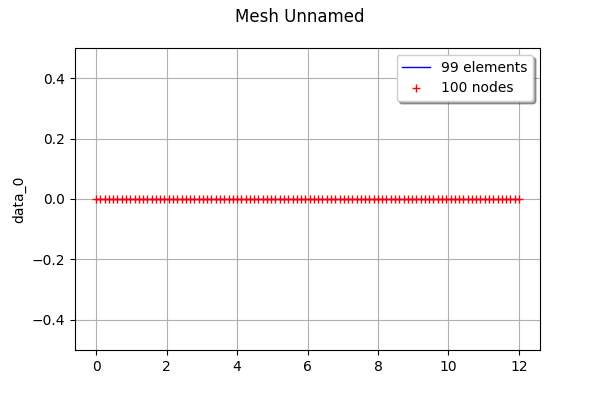

In [5]:
vertices = data[:, 0]
simplices = [[i, i + 1] for i in range(n_nodes - 1)]
mesh = ot.Mesh(vertices, simplices)
mesh.draw()

Create the ProcessSample from the data.

In [6]:
d_fields = 1
processSample = ot.ProcessSample(mesh, n_fields, d_fields)
for i in range(n_fields):
    trajectory = data[:, i + 1]
    processSample[i] = ot.Field(mesh, trajectory)

Compute HDRPlot.

In [7]:
# KL decomposition
reduction = othdr.KarhunenLoeveDimensionReductionAlgorithm(processSample, 2)
reduction.run()
reducedComponents = reduction.getReducedComponents()

# Distribution fit in reduced space
ks = ot.KernelSmoothing()
reducedDistribution = ks.build(reducedComponents)

The `HighDensityRegionAlgorithm` class plots the high density regions.

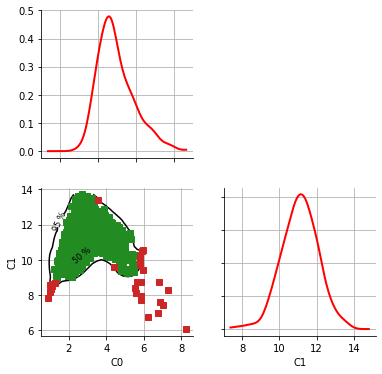

In [8]:
mydp = othdr.HighDensityRegionAlgorithm(
    reducedComponents, reducedDistribution, [0.95, 0.5]
)
mydp.run()
grid = mydp.draw(drawInliers=True)
view = otv.View(grid).getFigure().set_size_inches(6.0, 6.0)

In [9]:
hdr = othdr.ProcessHighDensityRegionAlgorithm(processSample, reducedComponents, reducedDistribution, [0.95, 0.5])
hdr.run()

We can visualize the reduced components as a cloud. 

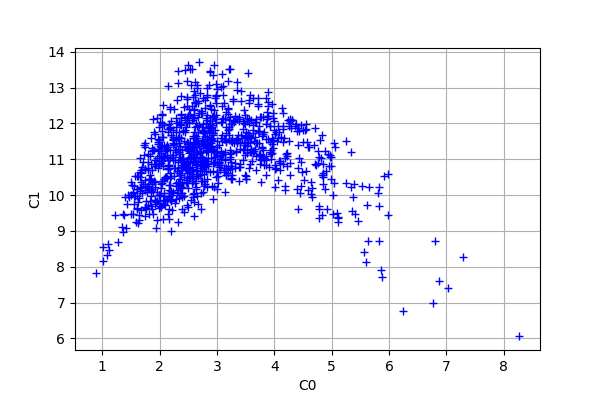

In [10]:
graph = ot.Graph("", "C0", "C1", True)
cloud = ot.Cloud(reducedComponents)
graph.add(cloud)
graph

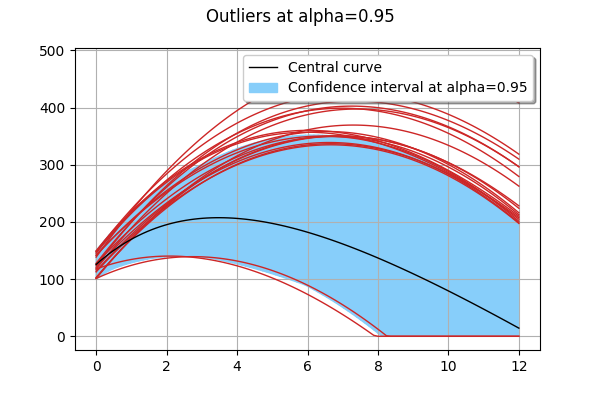

In [11]:
hdr.draw()

In [12]:
print("Outliers trajectories")
outlierIndices = hdr.computeIndices()
outlierIndices

Outliers trajectories


[34,
 99,
 108,
 244,
 319,
 324,
 349,
 356,
 546,
 646,
 704,
 716,
 749,
 774,
 782,
 795,
 922,
 927,
 971]